In [1]:
from dask.distributed import Client

client = Client("tls://192.168.150.62:8786")
client

<Client: 'tls://192.168.150.62:8786' processes=1 threads=1, memory=3.50 GiB>

In [108]:
import numpy as np
import awkward as ak
import hist
import coffea.processor as processor
from pprint import pprint
from itertools import combinations_with_replacement

In [128]:
def has_trigger(res):
    if 'trigger' in res['JetMET0_slimmed']['cutflow'].keys():
        for k in list(res['JetMET0_slimmed']['hists'].keys()):
            if ('anomaly_score_L1_' in k) or ('anomaly_score_HLT_' in k):
                return k.split('anomaly_score_')[1]
    else:
        return None

class AllHists(processor.ProcessorABC):
    def __init__(self, trigger_path='', extra_cut=''):
        
        self.run_dict = {
            'thresholds' : {
                '100hz' : {'name'  : '100 Hz', 'score' : 1280.375},
                '1khz'  : {'name'  : '1 kHz', 'score' : 982.3125},
                '5khz'  : {'name'  : '5 kHz', 'score' : 734.8125},
                '10khz' : {'name'  : '10 kHz', 'score' : 610.8125},
                'nocut' : {'name'  : 'Raw', 'score' : -100.},
            },
            'objects' : {'Jet' :
                            {
                             'cut' : [('pt', 30)],
                             'label' : 'j'
                            },
                        'Electron' : 
                            {
                             'cut' : [('pt', 10)],
                             'label' : 'e'
                            },
                        'Muon' : 
                             {
                             'cut' : [('pt', 10)],
                             'label' : '\mu'
                            },
                       }
        }

        self.sorted_keys = sorted( self.run_dict['thresholds'], 
                                   key=lambda i: self.run_dict['thresholds'][i]['score'])
        self.trigger_path = trigger_path
        self.extra_cut = extra_cut

    def process(self, events):
        output = {'cutflow' : {}}
        dataset = events.metadata['dataset']
        output['cutflow']['start'] = len(events)
        hist_dict = {}
        axo = events.axol1tl
        
        # Score plot
        h = hist.Hist.new \
            .Reg(100, 0, 1500, label='Anomaly Score') \
            .Double() \
            .fill(axo.score)
        hist_dict['anomaly_score'] = h

        # Trigger requirement
        if self.trigger_path:
            isL1 = True if self.trigger_path.startswith('L1') else False
            trig_br = getattr(events, 'L1' if isL1 else 'HLT')
            trig_path = self.trigger_path.split('L1_' if isL1 else 'HLT_')[1]
            events = events[
                getattr(trig_br,trig_path)
            ]
            output['cutflow']['trigger'] = len(events)
            axo = events.axol1tl

            h = hist.Hist.new \
                .Reg(100, 0, 1500, label='Anomaly Score') \
                .Double() \
                .fill(axo.score)
            hist_dict[f'anomaly_score_{self.trigger_path}'] = h
        
        
        for k in self.sorted_keys:
            axo = events.axol1tl
            events = events[axo.score >= self.run_dict['thresholds'][k]['score']]
            output['cutflow'][f'score_{k}'] = len(events)

            for obj,obj_dict in self.run_dict['objects'].items():
                cut_list = obj_dict['cut']
                label = obj_dict['label']
                
                col = getattr(events, obj)
                for var, cut in cut_list:
                    mask = (getattr(col,var) > cut)
                    col = col[mask]
                    
                    
                # Trigger object multiplicities
                h_mult = hist.Hist.new \
                    .Reg(40,0,40, label='$n_{'+label+'}$') \
                    .Double() \
                    .fill(ak.num(col,axis=1))
                hist_dict[f'n_{obj}_{k}'] = h_mult               
                
                # Trigger object kinematic variables
                h_pt = hist.Hist.new \
                    .Reg(50,0,2500, label='$p_{t}('+label+')$ [GeV]') \
                    .Double() \
                    .fill(ak.flatten(col.pt))
                hist_dict[f'pt_{obj}_{k}'] = h_pt
                
                h_eta = hist.Hist.new \
                    .Reg(20,-6,6, label='$\eta('+label+')$') \
                    .Double() \
                    .fill(ak.flatten(col.eta))
                hist_dict[f'eta_{obj}_{k}'] = h_eta
                
                h_phi = hist.Hist.new \
                    .Reg(20,-4,4, label='$\phi('+label+')$') \
                    .Double() \
                    .fill(ak.flatten(col.phi))
                hist_dict[f'phi_{obj}_{k}'] = h_phi
                
            # Di-object mass plots
            pairs = list(combinations_with_replacement(self.run_dict['objects'].keys(),2))
            for obj1, obj2 in pairs:
                isSame = obj1==obj2
                br_1 = getattr(events, obj1)
                br_2 = getattr(events, obj2)
                diObjMask = (ak.num(br_1) >= 2) if isSame else ((ak.num(br_1) >= 1) & (ak.num(br_2) >= 1))
                
                br_1 = br_1[diObjMask]
                br_2 = br_2[diObjMask]
                
                diObj = br_1[:, 0] + (br_1[:, 1] if isSame else br_2[:, 0])
                h_dimass = hist.Hist.new \
                    .Reg(50,0,5000, label='$m_{'+self.run_dict['objects'][obj1]['label']+self.run_dict['objects'][obj2]['label']+'}$ [GeV]') \
                    .Double() \
                    .fill(diObj.mass)
                hist_dict[f'm{obj1}{obj2}_{k}'] = h_dimass
                    
            output['hists'] = hist_dict
        return {dataset : output}

    def postprocess(self, accumulator):
        return accumulator

In [129]:
# proc_args = {'schema': processor.NanoAODSchema, 'client': client}
proc_args = {'schema': processor.NanoAODSchema}

evts = {
    'JetMET0_slimmed' : [
        'root://xcache//store/user/nzipper/L1AD_Ntuples/Run3_2023_Data_Production-wScores/L1Nano_JetMET_slimmed_wAxol1tlV3Scores.root'
    ],
}

hist_result = processor.run_uproot_job(
    evts,
    'Events',
    AllHists(trigger_path='L1_HTT320er'),
    processor.iterative_executor,
    proc_args,
    chunksize=150000,
)
# pprint(hist_result)

Output()

/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in
sqrt
  result = getattr(ufunc, method)(

In [6]:
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.dpi'] = 50
hep.style.use('CMS')
wgt = 1

In [7]:
thresholds = {
        '100hz' : {'name'  : '100 Hz', 'score' : 1280.375},
        '1khz'  : {'name'  : '1 kHz', 'score' : 982.3125},
        '5khz'  : {'name'  : '5 kHz', 'score' : 734.8125},
        '10khz' : {'name'  : '10 kHz', 'score' : 610.8125},
        'nocut' : {'name'  : 'Raw', 'score' : -100.},
}

## Score Plots

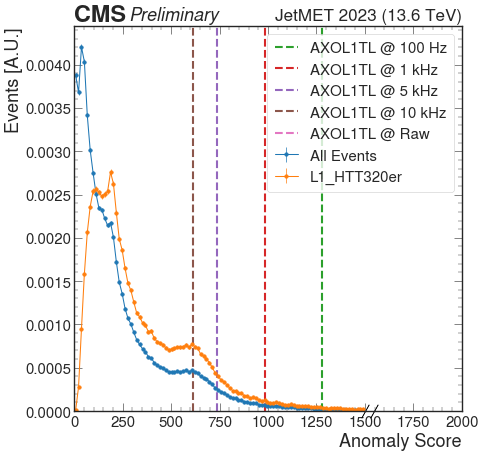

In [133]:
fig, ax = plt.subplots()
norm = True
hep.cms.label('Preliminary', data=True, lumi=None, year='JetMET 2023', com=13.6)
for k in hist_result['JetMET0_slimmed']['hists'].keys():
    if 'anomaly_score' in k:
        path = k.split("anomaly_score")[1].strip("_")
        label = path if path else "All Events"
        (hist_result['JetMET0_slimmed']['hists'][k]).plot(ax=ax, histtype='errorbar', linestyle='-', density=norm, label=label)
ax.set_xlim(0, 2000)
for th in thresholds.values():
    ax.axvline(x=th['score'], 
               label='AXOL1TL @ '+th['name'], 
               color=ax._get_lines.get_next_color(),
               linestyle='--',
               linewidth=3,
)
# plt.yscale('log')
plt.ylabel('Events [A.U.]', loc='top')
ax.legend(frameon=True);

## Kinematic Plots

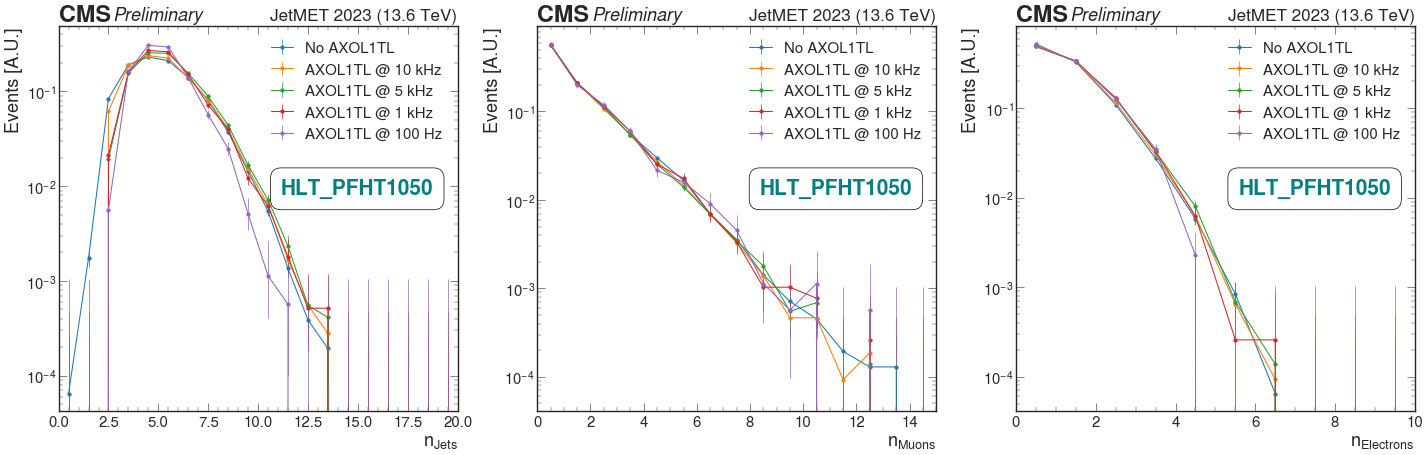

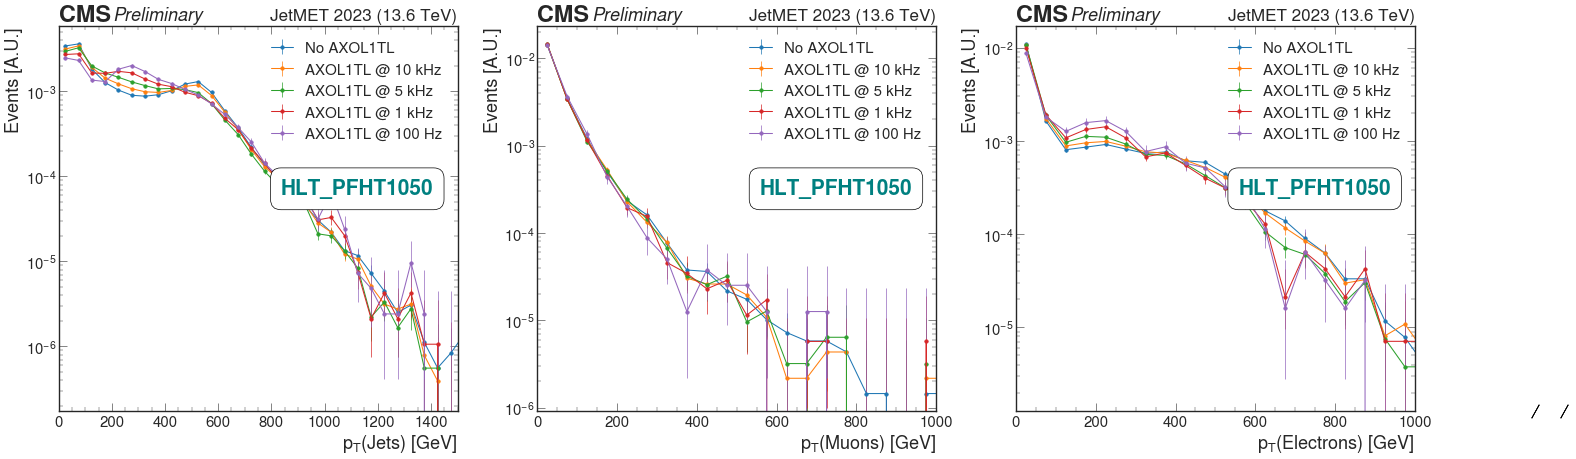

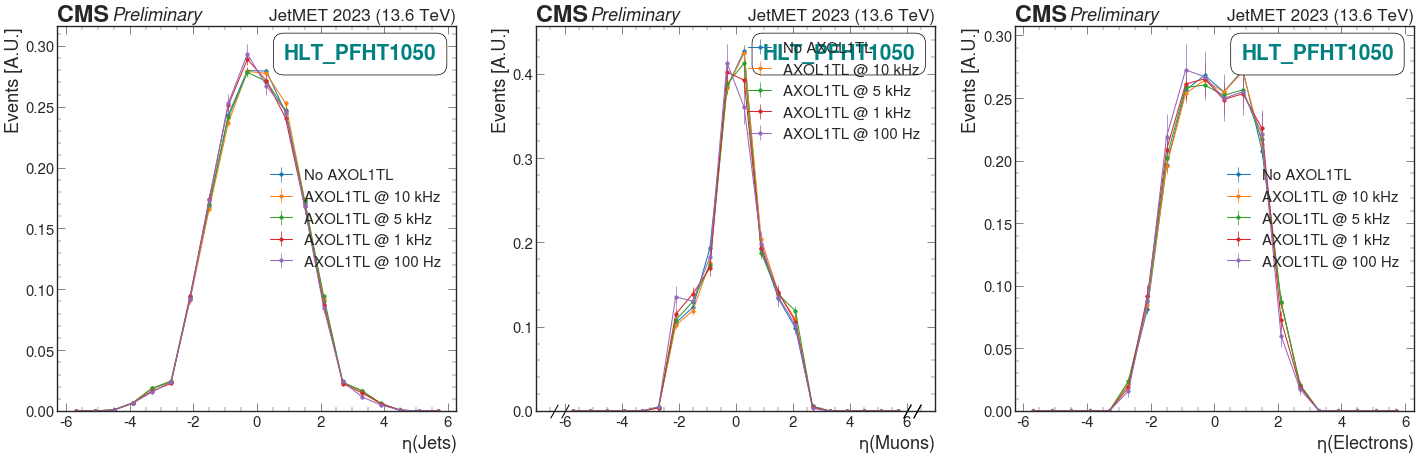

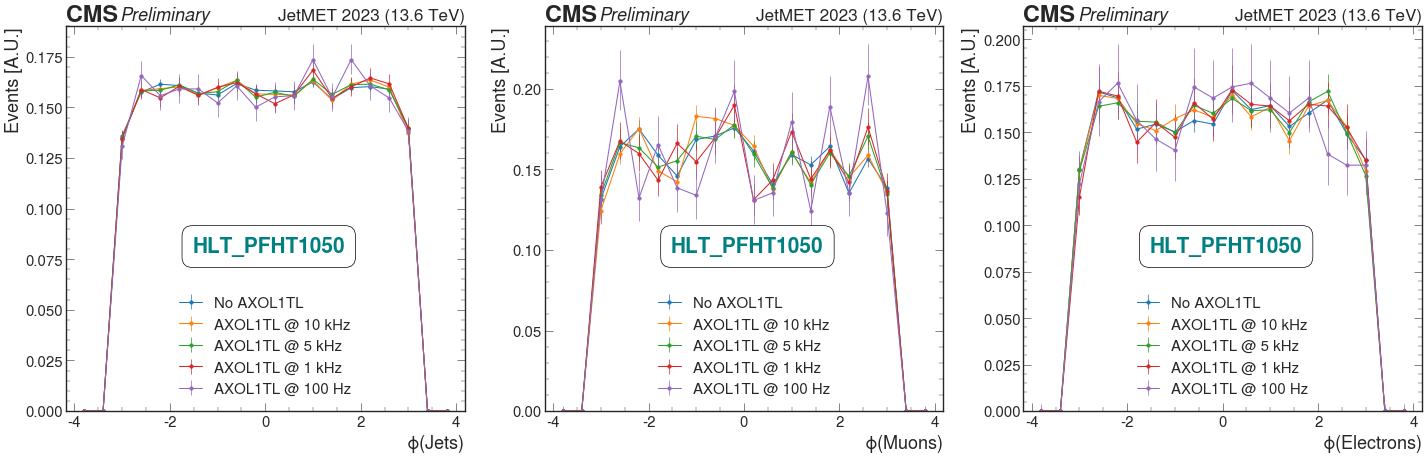

In [106]:
# Multiplicity
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,20), (0,15), (0,10)]
norm = True
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    (hist_result['JetMET0_slimmed']['hists'][f'n_{obj}_nocut'] * wgt).plot(ax=ax[i], histtype='errorbar', label='No AXOL1TL', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'n_{obj}_10khz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 10 kHz', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'n_{obj}_5khz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 5 kHz', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'n_{obj}_1khz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 1 kHz', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'n_{obj}_100hz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 100 Hz', linestyle='-', density=norm)
    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year='JetMET 2023', com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$n_{{{obj+"s"}}}$', loc='right')
    ax[i].set_ylabel('Events [A.U.]', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()
    
    trig = has_trigger(hist_result)
    if trig:
        ax[i].text(0.94, 0.55, trig, fontweight='bold', transform=ax[i].transAxes,
            verticalalignment='bottom', horizontalalignment='right',
            color='teal', fontsize=30, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.5'))

# Pt
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,1500), (0,1000), (0,1000)]
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    (hist_result['JetMET0_slimmed']['hists'][f'pt_{obj}_nocut'] * wgt).plot(ax=ax[i], histtype='errorbar', label='No AXOL1TL', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'pt_{obj}_10khz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 10 kHz', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'pt_{obj}_5khz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 5 kHz', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'pt_{obj}_1khz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 1 kHz', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'pt_{obj}_100hz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 100 Hz', linestyle='-', density=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year='JetMET 2023', com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$p_{{T}}({obj+"s"})$ [GeV]', loc='right')
    ax[i].set_ylabel('Events [A.U.]', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()
    
    trig = has_trigger(hist_result)
    if trig:
        ax[i].text(0.94, 0.55, trig, fontweight='bold', transform=ax[i].transAxes,
            verticalalignment='bottom', horizontalalignment='right',
            color='teal', fontsize=30, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.5'))

# Eta  
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    (hist_result['JetMET0_slimmed']['hists'][f'eta_{obj}_nocut'] * wgt).plot(ax=ax[i], histtype='errorbar', label='No AXOL1TL', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'eta_{obj}_10khz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 10 kHz', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'eta_{obj}_5khz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 5 kHz', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'eta_{obj}_1khz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 1 kHz', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'eta_{obj}_100hz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 100 Hz', linestyle='-', density=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year='JetMET 2023', com=13.6)
    ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
    ax[i].set_ylabel('Events [A.U.]', loc='top')
    # ax[i].set_yscale('log')
    ax[i].legend()

    trig = has_trigger(hist_result)
    if trig:
        ax[i].text(0.95, 0.9, trig, fontweight='bold', transform=ax[i].transAxes,
            verticalalignment='bottom', horizontalalignment='right',
            color='teal', fontsize=30, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.5'))

# Phi
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
for i, obj in enumerate(['Jet', 'Muon', 'Electron']):
    (hist_result['JetMET0_slimmed']['hists'][f'phi_{obj}_nocut'] * wgt).plot(ax=ax[i], histtype='errorbar', label='No AXOL1TL', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'phi_{obj}_10khz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 10 kHz', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'phi_{obj}_5khz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 5 kHz', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'phi_{obj}_1khz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 1 kHz', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'phi_{obj}_100hz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 100 Hz', linestyle='-', density=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year='JetMET 2023', com=13.6)
    ax[i].set_xlabel(f'$\phi({obj+"s"})$', loc='right')
    ax[i].set_ylabel('Events [A.U.]', loc='top')
    # ax[i].set_yscale('log')
    ax[i].legend()

    trig = has_trigger(hist_result)
    if trig:
        ax[i].text(0.7, 0.4, trig, fontweight='bold', transform=ax[i].transAxes,
            verticalalignment='bottom', horizontalalignment='right',
            color='teal', fontsize=30, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.5'))

## Di-Object Mass Plots

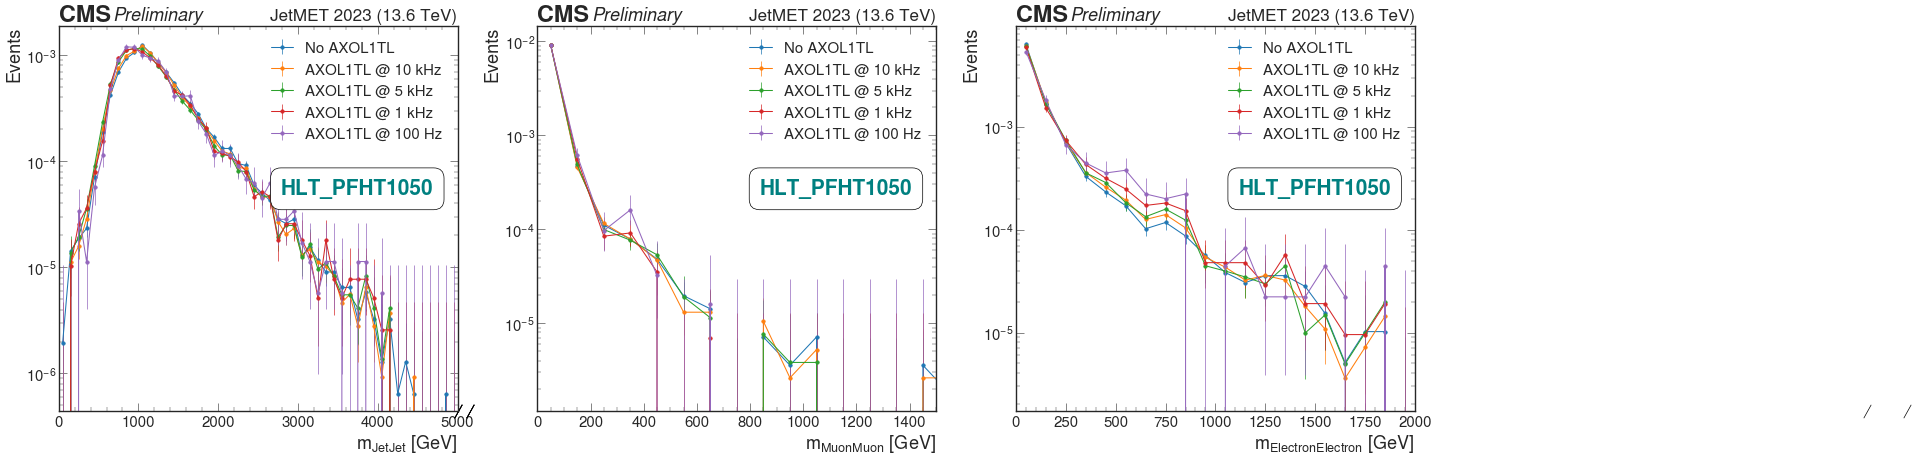

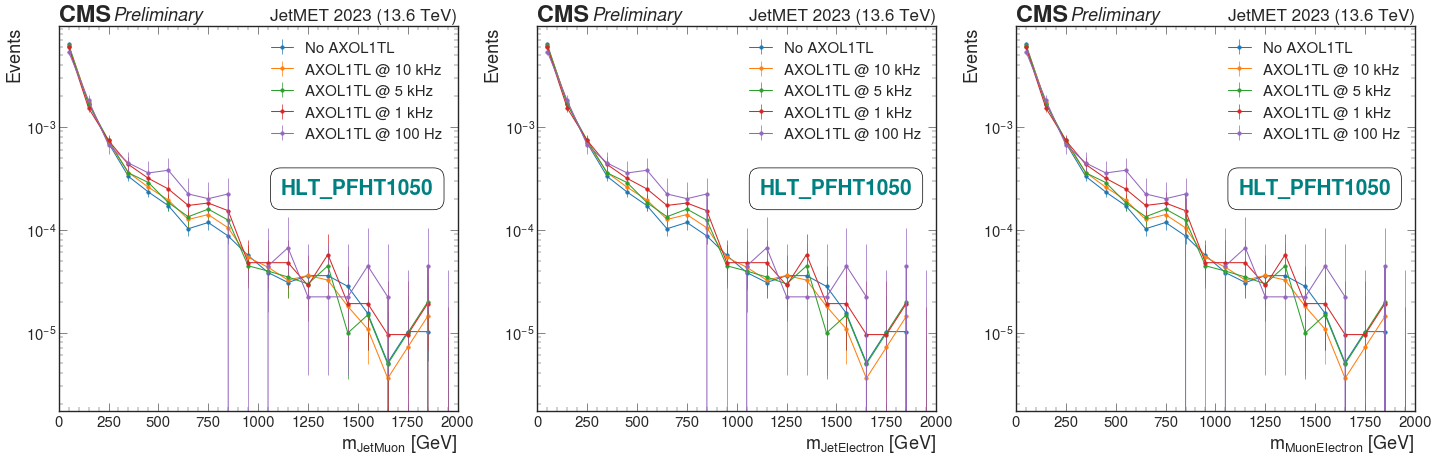

In [89]:
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,5000), (0,1500), (0,2000)]
norm = True
for i, obj in enumerate(['Jet','Muon','Electron']):
    (hist_result['JetMET0_slimmed']['hists'][f'm{obj+obj}_nocut'] * wgt).plot(ax=ax[i], histtype='errorbar', label='No AXOL1TL', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'm{obj+obj}_10khz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 10 kHz', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'm{obj+obj}_5khz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 5 kHz', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'm{obj+obj}_1khz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 1 kHz', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'm{obj+obj}_100hz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 100 Hz', linestyle='-', density=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year='JetMET 2023', com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$m_{{{obj+obj}}}$ [GeV]', loc='right')
    ax[i].set_ylabel('Events', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()
    
    trig = has_trigger(hist_result)
    if trig:
        ax[i].text(0.94, 0.55, trig, fontweight='bold', transform=ax[i].transAxes,
            verticalalignment='bottom', horizontalalignment='right',
            color='teal', fontsize=30, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.5'))
        
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,2000), (0,2000), (0,2000)]
norm = True
for i, (obj1,obj2) in enumerate([('Jet','Muon'),('Jet','Electron'),('Muon','Electron')]):
    (hist_result['JetMET0_slimmed']['hists'][f'm{obj+obj}_nocut'] * wgt).plot(ax=ax[i], histtype='errorbar', label='No AXOL1TL', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'm{obj+obj}_10khz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 10 kHz', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'm{obj+obj}_5khz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 5 kHz', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'm{obj+obj}_1khz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 1 kHz', linestyle='-', density=norm)
    (hist_result['JetMET0_slimmed']['hists'][f'm{obj+obj}_100hz'] * wgt).plot(ax=ax[i], histtype='errorbar', label='AXOL1TL @ 100 Hz', linestyle='-', density=norm)

    hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year='JetMET 2023', com=13.6)
    ax[i].set_xlim(*xrange[i])
    ax[i].set_xlabel(f'$m_{{{obj1+obj2}}}$ [GeV]', loc='right')
    ax[i].set_ylabel('Events', loc='top')
    ax[i].set_yscale('log')
    ax[i].legend()
    
    trig = has_trigger(hist_result)
    if trig:
        ax[i].text(0.94, 0.55, trig, fontweight='bold', transform=ax[i].transAxes,
            verticalalignment='bottom', horizontalalignment='right',
            color='teal', fontsize=30, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.5'))